In [3]:
import pymc3 as pm
import theano.tensor as tt
import theano.tensor.slinalg as sla
import theano.tensor.nlinalg as nla
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Read Data 

In [9]:
x , y = np.loadtxt( 'test_data.txt', delimiter=',', skiprows = 1,   unpack=True)

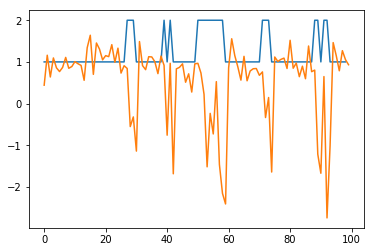

In [15]:
plt.plot(x[1:100])
plt.plot(y[0:100])


In [18]:
N_states = 2
N_chain = len(y)

# Transition probability stochastic
theta = np.ones((N_states,N_states)) + 1.
alphaA = np.ones(N_states)*2.1
betaA = np.ones(N_states)*1.1
alphaS = np.ones(N_states)*2.1
betaS = np.ones(N_states)*1.1

In [19]:
theta

array([[2., 2.],
       [2., 2.]])

In [20]:
alphaA

array([2.1, 2.1])

In [21]:
betaA

array([1.1, 1.1])

In [23]:
class HMMStatesN(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P : tensor
        transition probability
        shape = (N_states,N_states)
        
    PA : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, PA=None, P=None, N_states=2,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.P = P
        self.PA = PA
        self.k = N_states
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        P = self.P
        PA = self.PA
        
        # calculate equilibrium
        
        # now we need to create an array with probabilities
        # so that for x=A: PA=P1, PB=(1-P1)
        # and for x=B: PA=P2, PB=(1-P2)
        #P = tt.switch(x[:-1],P1,P2)
        
        PS = P[x[:-1]]
                
        x_i = x[1:]
        ou_like = pm.Categorical.dist(PS).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)

In [24]:
class HMMGaussianEmissionsN(pm.Continuous):
    """
    Hidden Markov Model Gaussian Emissions
    Parameters
    ----------
    A : tensor
        prior for Gaussian emission mu
        shape = (2,N_states)
        
    S : tensor
        prior for Gaussian emission width
        shape = (2,N_states)
    
    states : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, A=None, S=None, states=None,
                 *args, **kwargs):
        super(HMMGaussianEmissionsN, self).__init__(*args, **kwargs)
        self.A = A
        self.S = S
        self.states = states
        self.mean = 0.

    def logp(self, x):
        A = self.A
        S = self.S
        states = self.states
        
        AS = A[states]        
        SS = S[states]
        
        ou_like = pm.Normal.dist(mu=AS,sd=SS).logp(x)
        return tt.sum(ou_like)

In [37]:
from scipy import optimize
with pm.Model() as model:
    # N_states state model
    #P = tt.stack( [pm.Dirichlet('P_'+str(i), a=np.ones(N_states)) for i in range(N_states)] )
    
    P = pm.Dirichlet('P', a=np.ones((N_states,N_states)), shape=(N_states,N_states))
    A = pm.InverseGamma('A',alpha=alphaA, beta=betaA, shape=(N_states))
    S = pm.InverseGamma('S', alpha=alphaS, beta=betaS, shape=(N_states))
    
#    Pfull = tt.dmatrix('Pfull')
#    PA = tt.dmatrix('PA')
    AA = tt.dmatrix('AA')
        
    AA = tt.eye(N_states) - P + tt.ones(shape=(N_states,N_states))
    
    PA = pm.Deterministic('PA',sla.solve(AA.T,tt.ones(shape=(N_states))))
    
    states = HMMStatesN('states',PA=PA, P=P, N_states=N_states, shape=(len(y)))
    
    emission = HMMGaussianEmissionsN('emission',A = A, S = S,states=states,observed = y)
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    step1 = pm.Metropolis(vars=[P,A,S,PA,emission])
    step2 = pm.CategoricalGibbsMetropolis(vars=[states])
    trace = pm.sample(10000, start=start, step=[step1,step2])    
    

/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -1,408.9:   5%|▍         | 235/5000 [00:01<00:20, 227.42it/s]


Optimization terminated successfully.
         Current function value: 1408.918917
         Iterations: 3
         Function evaluations: 235


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [P_stickbreaking__]
>>Metropolis: [S_log__]
>>Metropolis: [A_log__]
>CategoricalGibbsMetropolis: [states]
100%|██████████| 10500/10500 [1:34:47<00:00,  1.85it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f27436fb550>,
      dtype=object)

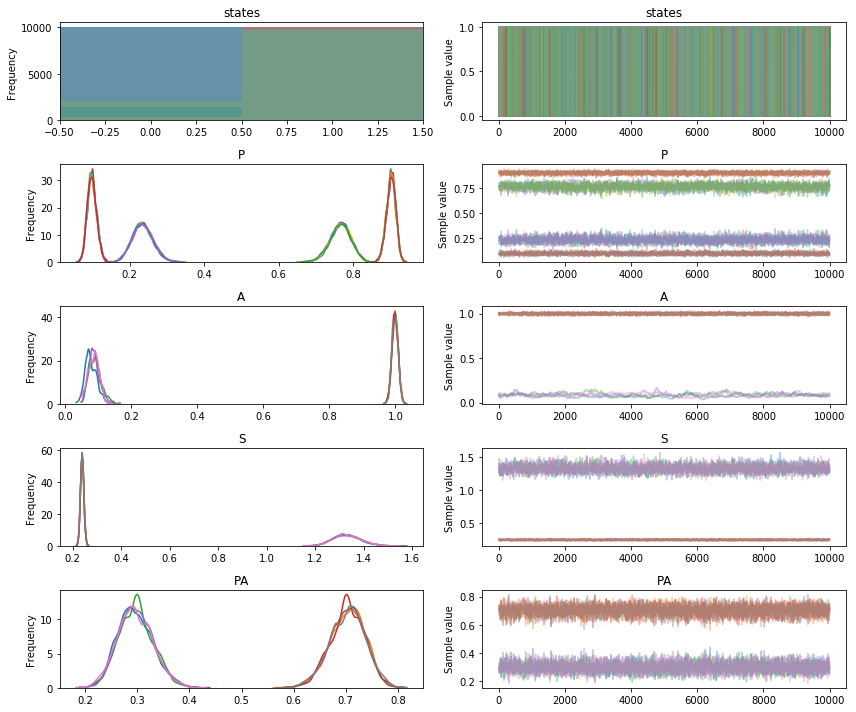

In [38]:
pm.traceplot(trace)